In [15]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import math
import numpy as np
from scipy import stats

In [16]:
# HIDDEN
def football(r):
    x = np.random.normal(0, 1, 500)
    z = np.random.normal(0, 1, 500)
    y = r*x + (np.sqrt(1-r**2))*z
    plots.scatter(x, y)
    plots.xlim(-4, 4)
    plots.ylim(-4, 4)
    plots.axes().set_aspect('equal')
    plots.plot([-4, 4], [-4*r,4*r], color='g', lw=1)
    if r >= 0:
        plots.plot([-4,4],[-4,4], lw=1, color='r')
    else:
        plots.plot([-4,4], [4,-4], lw=1, color='r')

## Measuring the relation between two variables

In the last chapter, we began developing a method that would allow us to estimate the birth weight of babies based on the number of gestational days. In this chapter, we develop a more general approach to measuring the relation between two variables and estimating the value of one variable given the value of another. 

Our proposed estimate in the example of birth weights was simple: 

- Find the ratio of the birth weight to gestational days for each baby in the sample. 
- Find the median of the ratios. 
- For a new baby, multiply the number of gestational days by that median. This is our estimate of the baby's birth weight.

Here are the data; the column ``r_bwt_gd`` contains the ratio of birth weight to gestational days.

In [17]:
baby = Table.read_table('baby.csv')
baby['r_bwt_gd'] = baby['birthwt']/baby['gest_days']
baby

birthwt,gest_days,mat_age,mat_ht,mat_pw,m_smoker,r_bwt_gd
120,284,27,62,100,0,0.422535
113,282,33,64,135,0,0.400709
128,279,28,64,115,1,0.458781
108,282,23,67,125,1,0.382979
136,286,25,62,93,0,0.475524
138,244,33,62,178,0,0.565574
132,245,23,65,140,0,0.538776
120,289,25,62,125,0,0.415225
143,299,30,66,136,1,0.478261
140,351,27,68,120,0,0.39886


The median of the ratios is just about 0.429 ounces per day:

In [18]:
np.median(baby['r_bwt_gd'])

0.42907801418439717

So we can construct our proposed estimate by multiplying the number of gestational days of each baby by 0.429. The column ``est_wt`` contains these estimates.

In [19]:
baby['est_bwt'] = 0.429*baby['gest_days']
baby.drop('r_bwt_gd')

birthwt,gest_days,mat_age,mat_ht,mat_pw,m_smoker,est_bwt
120,284,27,62,100,0,121.836
113,282,33,64,135,0,120.978
128,279,28,64,115,1,119.691
108,282,23,67,125,1,120.978
136,286,25,62,93,0,122.694
138,244,33,62,178,0,104.676
132,245,23,65,140,0,105.105
120,289,25,62,125,0,123.981
143,299,30,66,136,1,128.271
140,351,27,68,120,0,150.579


Because of the way they are constructed – by multiplying the gestational days by a constant – The estimates all lie on a straight line. 

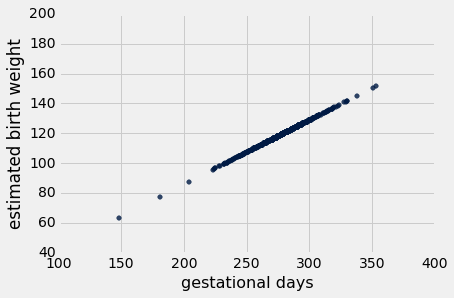

In [53]:
bb0 = baby.select(['gest_days', 'est_bwt'])
bb0.scatter('gest_days')
plots.ylim(40,200)
plots.xlabel('gestational days')
plots.ylabel('estimated birth weight')
None

A natural question to ask is, "How good are these estimates?" To get a sense of the answer, let us visualize the data by drawing a *scatter plot* of birth weight versus gestational days. The scatter plot consists of one point for each of the 1,174 babies in the sample. The horizontal axis represents the number of gestational days and the vertical axis represents the birth weight. 

The plot is generated by using a ``Table`` method called ``scatter``. The argument is the label of the column that contains the values to be plotted on the horizontal axis. For each of the other columns in the table, a scatter diagram is produced with the corresponding variable on the vertical axis. To generate just one scatter plot, therefore, we start by selecting only the variables that we need.

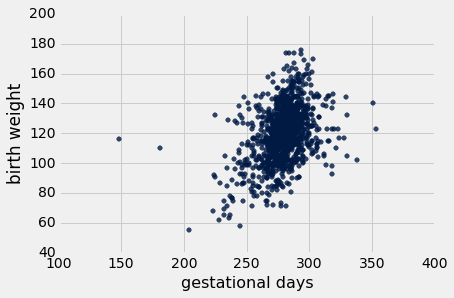

In [54]:
gd_bwt = baby.select(['gest_days', 'birthwt'])
gd_bwt.scatter('gest_days')
plots.xlabel('gestational days')
plots.ylabel('birth weight')
None

How good are the estimates that we calculated? To get a sense of this, we will re-draw the scatter plot and overlay the line of estimates. This can be done by using the argument ``overlay=True`` when we call ``scatter``.

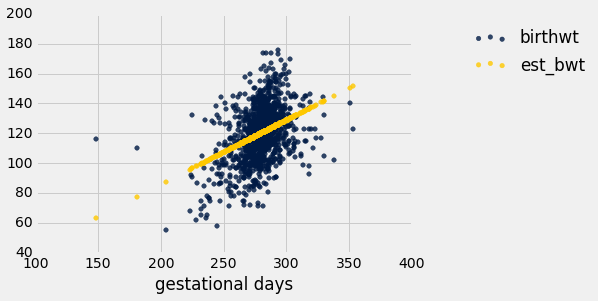

In [57]:
gd_bwt_est = baby.select(['gest_days', 'birthwt', 'est_bwt'])
gd_bwt_est.scatter('gest_days', overlay=True)
plots.xlabel('gestational days')
None

The line appears to be roughly in the center of the scatter diagram; if we use the line for estimation, the amount of over-estimation will be comparable to the amount of under-estimation, roughly speaking. This is a natural criterion for determining a "good" straight line of estimates.

Let us see if we can formalize this idea and create a "best" straight line of estimates.

To see roughly where such a line must lie, we will start by attempting to estimate maternal pregnancy weight based on the mother's height. The heights have been measured to the nearest inch, resulting in the vertical stripes in the scatter plot.

In [23]:
ht_pw = baby.select(['mat_ht', 'mat_pw'])

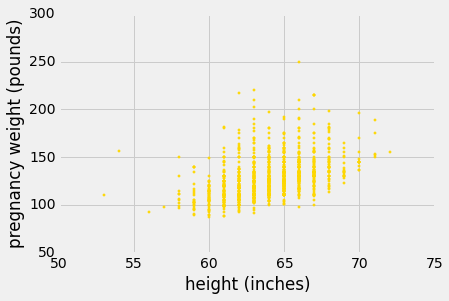

In [76]:
plots.scatter(ht_pw['mat_ht'], ht_pw['mat_pw'], s=5, color='gold')
plots.xlabel('height (inches)')
plots.ylabel('pregnancy weight (pounds)')
None

Suppose we know that one of the women is 65 inches tall. What would be our estimate for her pregnancy weight?

We know that the point corresponding to this woman must be on the vertical strip at 65 inches. A natural estimate of her pregnancy weight is the average of the weights in that strip; the rough size of the error in this estimate will be the SD of the weights in the strip.

For a woman who is 60 inches tall, our estimate of pregnancy weight would be the average of the weights in the vertical strip at 60 inches. And so on.

Here are the average pregnancy weights for all the values of the heights.

In [25]:
v_means = ht_pw.group('mat_ht', np.mean)
v_means

mat_ht,mat_pw mean
53,110
54,156
56,93
57,98
58,112.8
59,109.208
60,109.556
61,118.556
62,120.756
63,125.894


In the figure below, these averages are overlaid on the scatter plot of pregnancy weight versus height, and appear as green dots at the averages of the vertical strips. The graph of green dots is called the *graph of averages*. A graph of averages shows the average of the variable on the vertical axis, for each value of the variable on the horizontal axis. It can be used for estimating the variable on the vertical axis, given the variable on the horizontal.

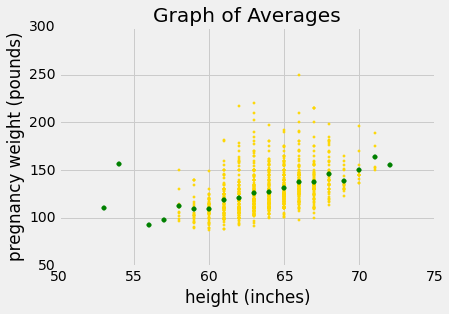

In [60]:
plots.scatter(baby['mat_ht'], baby['mat_pw'], s=5, color='gold')
plots.scatter(v_means['mat_ht'], v_means['mat_pw mean'], color='g')
plots.xlabel('height (inches)')
plots.ylabel('pregnancy weight (pounds)')
plots.title('Graph of Averages')
None

For these two variables, the graph of averages looks roughly linear: the green dots are fairly close to a straight line for much of the scatter. That straight line is the "best" straight line for estimating pregnancy weight based on height.

To identify the line more precisely, let us examine the oval or *football shaped* scatter plot. 

First, we note that the position of the line is a property of the shape of the scatter, and is not affected by the units in which the heights and weights were measured. Therefore, we will measure both variables in standard units.

## Identifying the line that goes through the graph of averages

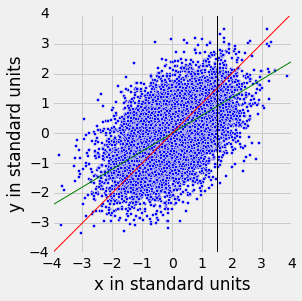

In [77]:
x_demo = np.random.normal(0, 1, 10000)
z_demo = np.random.normal(0, 1, 10000)
y_demo = 0.5*x_demo + np.sqrt(.75)*z_demo
plots.scatter(x_demo, y_demo, s=10)
plots.xlim(-4, 4)
plots.ylim(-4, 4)
plots.axes().set_aspect('equal')
plots.plot([-4, 4], [-4*0.6,4*0.6], color='g', lw=1)
plots.plot([-4,4],[-4,4], lw=1, color='r')
plots.plot([1.5,1.5], [-4,4], lw=1, color='k')
plots.xlabel('x in standard units')
plots.ylabel('y in standard units')
None

Here is a football shaped scatter plot. We will follow the usual convention of calling the variable along the horizontal axis $x$ and the variable on the vertical axis $y$. Both variables are in standard units. This implies that the center of the football, corresponding to the point where both variables are at their average, is the origin (0, 0). 

Because of the symmetry of the figure, resulting from both variables being measured in standard units, it is natural to see whether the 45 degree line is the best line for estimation. The 45 degree line has been drawn in red. For points on the red line, the value of $x$ in standard units is equal to the value of $y$ in standard units.

Suppose the given value of $x$ is at the average, in other words at 0 on the standard units scale. The points corresponding to that value of $x$ are on the vertical strip at $x$ equal to 0 standard units. The average of the values of $y$ in that strip can be seen to be at 0, by symmetry. So the straight line of estimates should pass through (0, 0).

A careful look at the vertical strips shows that the red line does not work for estimating $y$ based on other values of $x$. For example, suppose the value of $x$ is 1.5 standard units. The black vertical line corresponds to this value of $x$. The points on the scatter whose value of $x$ is 1.5 standard units are the blue dots on the black line; their values on the vertical scale range from about 2 to about 3. It is clear from the figure that the red line does not pass through the average of these points; the red line is too steep.

To get to the average of the vertical strip at $x$ equal to 1.5 standard units, we have to come down from the red line to the center of the strip. The green line is at that point; it has been drawn by connecting the center of the strip to the point (0, 0) and then extending the line on both sides.

The scatter plot is linear, so the green line picks off the centers of the vertical strips. It is the line that should be used to estimate $y$ based on $x$ when both variables are in standard units. 

The slope of the red line is equal to 1. The green line is less steep, and so its slope is less than 1. Because it is sloping upwards in the figure, we have established that its slope is between 0 and 1.


**Summary.** When both variables are measured in standard units, the best line for estimating $y$ based on $x$ is less steep than the 45 degree line and thus has slope less than one. The discussion above was based on a scatter plot sloping upwards, and so the slope of the best line is a number between 0 and 1. For scatter diagrams sloping downwards, the slope would be a number between 0 and -1. For the slope to be close to -1 or 1, the red and green lines must be close, or in other words, the scatter diagram must be tightly clustered around a straight line.

## The Correlation Coefficient

This number between -1 and 1 is called the *correlation coefficient* and is said to measure the *correlation* between the two variables.

- The correlation coefficient $r$ is a number between $-1$ and 1.
- When both the variables are measured in standard units, $r$ is the slope of the "best straight line" for estimating $y$ based on $x$.
- $r$ measures the extent to which the scatter plot clusters around a straight line of positive or negative slope.

The function ``football`` takes a value of $r$ as its argument and generates a football shaped scatter plot with correlation roughly $r$. The red line is the 45 degree line $y=x$, corresponding to points that are the same number of standard units in both variables. The green line, $y = rx$, is a smoothed version of the graph of averages. Points on the green line correspond to our estimates of the variable on the vertical axis, given values on the horizontal.

Call ``football`` a few times, with different values of $r$ as the argument, and see how the football changes. Positive $r$ corresponds to positive association: above-average values of one variable are associated with above-average values of the other, and the scatter plot slopes upwards.

Notice also that the bigger the absolute value of $r$, the more clustered the points are around the green line of averages, and the closer the green line is to the red line of equal standard units.

When $r=1$ the scatter plot is perfectly linear and slopes upward. When $r=-1$, the scatter plot is perfectly linear and slopes downward. When $r=0$, the scatter plot is a formless cloud around the horizontal axis, and the variables are said to be *uncorrelated*.

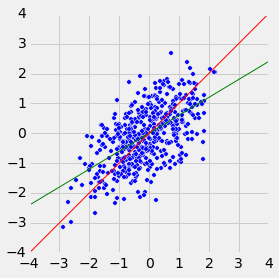

In [61]:
# Football shaped scatter, both axes in standard units
# Argument of function: correlation coefficient r
# red line: slope = 1 (or -1)
# green line: smoothed graph of averages, slope = r
# Use the green line for estimating y based on x

football(0.6)

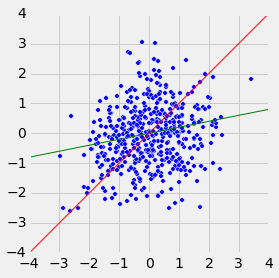

In [63]:
football(0.2)

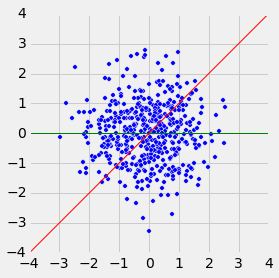

In [65]:
football(0)

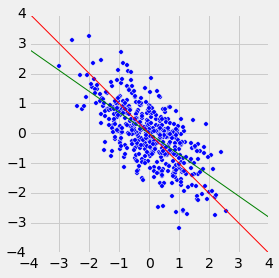

In [68]:
football(-0.7)

###Calculating $r$

The formula for $r$ is not apparent from our observations so far; it has a mathematical basis that is outside the scope of this class. However, the calculation is straightforward and helps us understand several of the properties of $r$.

**Formula for $r$**:

- $r$ is the average of the products of the two variables, when both variables are measured in standard units.

Here are the steps in the calculation. We will apply the steps to a simple table of values of $x$ and $y$.

In [29]:
t = Table([np.arange(1,7,1), [2, 3, 1, 5, 2, 7]], ['x','y'])
t

x,y
1,2
2,3
3,1
4,5
5,2
6,7


Based on the scatter plot, we expect that $r$ will be positive but not equal to 1.

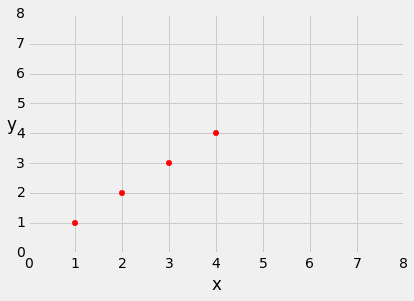

In [78]:
plots.scatter(t['x'], t['y'], s=30, color='r')
plots.xlim(0, 8)
plots.ylim(0, 8)
plots.xlabel('x')
plots.ylabel('y', rotation=0)
None

**Step 1.** Convert each variable to standard units.

In [31]:
t['x_su'] = (t['x'] - np.mean(t['x']))/np.std(t['x'])
t['y_su'] = (t['y'] - np.mean(t['y']))/np.std(t['y'])
t

x,y,x_su,y_su
1,2,-1.46385,-0.648886
2,3,-0.87831,-0.162221
3,1,-0.29277,-1.13555
4,5,0.29277,0.811107
5,2,0.87831,-0.648886
6,7,1.46385,1.78444


**Step 2.** Multiply each pair of standard units.

In [32]:
t['su_product'] = t['x_su']*t['y_su']
t

x,y,x_su,y_su,su_product
1,2,-1.46385,-0.648886,0.949871
2,3,-0.87831,-0.162221,0.142481
3,1,-0.29277,-1.13555,0.332455
4,5,0.29277,0.811107,0.237468
5,2,0.87831,-0.648886,-0.569923
6,7,1.46385,1.78444,2.61215


**Step 3.** $r$ is the average of the products computed in Step 2.

In [33]:
# r is the average of the products of standard units

r = np.mean(t['su_product'])
r

0.61741639718977093

As expected, $r$ is positive but not equal to 1.

The calculation shows that:

- $r$ is a pure number; it has no units. This is because $r$ is based on standard units.
- $r$ is unaffected by changing the units on either axis. This too is because $r$ is based on standard units.
- $r$ is unaffected by switching the axes. Algebraically, this is because the product of standard units does not depend on which variable is called $x$ and which $y$. Geometrically, switching axes reflects the scatter plot about the line $y=x$, but does not change the amount of clustering nor the sign of the association.

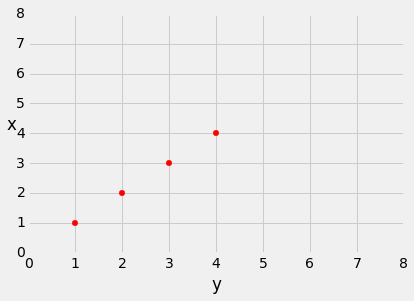

In [69]:
plots.scatter(t['y'], t['x'], s=30, color='r')
plots.xlim(0, 8)
plots.ylim(0, 8)
plots.xlabel('y')
plots.ylabel('x', rotation=0)
None

The NumPy method ``corrcoef`` can be used to calculate $r$. The arguments are an array containing the values of $x$ and another containing the corresponding values of $y$. The program evaluates to a *correlation matrix*, which is this case is a 2x2 table indexed by $x$ and $y$. The top left element is the correlation between $x$ and $x$, and hence is 1. The top right element is the correlation between $x$ and $y$, which is equal to the correlation between $y$ and $x$ displayed on the bottom left. The bottom right element is 1, the correlation between $y$ and $y$.

In [35]:
np.corrcoef(t['x'], t['y'])

array([[ 1.       ,  0.6174164],
       [ 0.6174164,  1.       ]])

For the purposes of this class, correlation matrices are unnecessary. We will define our own function ``corr`` to compute $r$, based on the formula that we used above. The arguments are the name of the table and the labels of the columns containing the two variables. The function returns the mean of the products of standard units, which is $r$.

In [36]:
def corr(table, column_A, column_B):
    x = table[column_A]
    y = table[column_B]
    return np.mean(((x-np.mean(x))/np.std(x))*((y-np.mean(y))/np.std(y)))

Here are examples of calling the function. Notice that it gives the same answer to the correlation between $x$ and $y$ as we got by using ``np.corrcoef`` and earlier by direct application of the formula for $r$. Notice also that the correlation between maternal age and birth weight is very low, confirming the lack of any upward or downward trend in the scatter diagram. 

In [37]:
corr(t, 'x', 'y')

0.61741639718977093

In [38]:
corr(baby, 'birthwt', 'gest_days')

0.40754279338885108

In [39]:
corr(baby, 'birthwt', 'mat_age')

0.026982911002929499

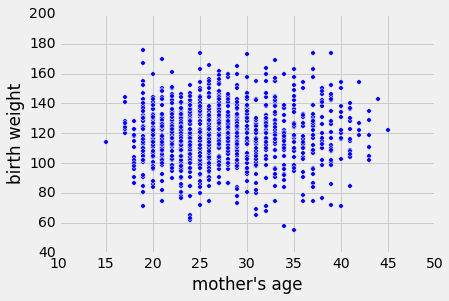

In [70]:
plots.scatter(baby['mat_age'], baby['birthwt'])
plots.xlabel("mother's age")
plots.ylabel('birth weight')
None

###  Properties of Correlation

Correlation is a simple and powerful concept, but it is sometimes misused. Before using $r$, it is important to be aware of the following points.

- Correlation only measures association. Correlation does not imply causation. Though the correlation between the weight and the math ability of children in a school district may be positive, that does not mean that doing math makes children heavier or that putting on weight improves the children's math skills. Age is a confounding variable: older children are both heavier and better at math than younger children, on average.

- Correlation measures **linear** association. Variables that have strong non-linear association might have very low correlation. Here is an example of variables that have a perfect quadratic relation $y = x^2$ but have correlation equal to 0.

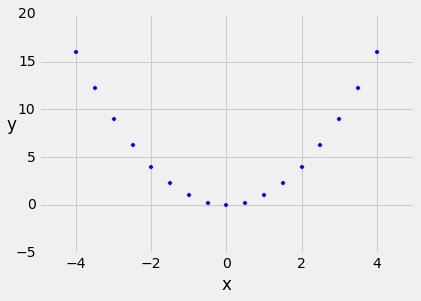

In [71]:
tsq = Table([np.arange(-4, 4.1, 0.5), np.arange(-4, 4.1, 0.5)**2],
           ['x','y'])
plots.scatter(tsq['x'], tsq['y'])
plots.xlabel('x')
plots.ylabel('y', rotation=0)
None

In [42]:
corr(tsq, 'x', 'y')

0.0

- Outliers can have a big effect on correlation. Here is an example where a scatter plot for which $r$ is equal to 1 is turned into a plot for which $r$ is equal to 0, by the addition of just one outlying point.

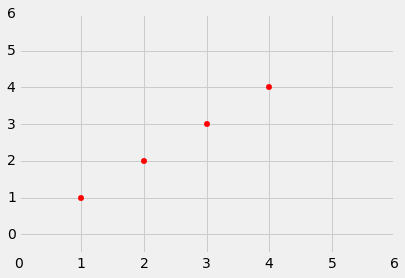

In [72]:
t = Table([[1,2,3,4],[1,2,3,4]], ['x','y'])
plots.scatter(t['x'], t['y'], s=30, color='r')
plots.xlim(0, 6)
plots.ylim(-0.5,6)
None

In [44]:
corr(t, 'x', 'y')

1.0

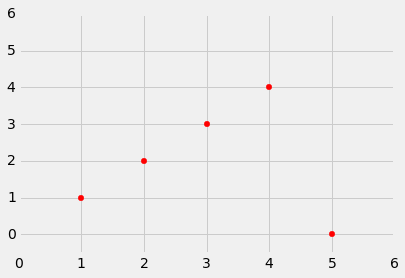

In [74]:
t_outlier = Table([[1,2,3,4,5],[1,2,3,4,0]], ['x','y'])
plots.scatter(t_outlier['x'], t_outlier['y'], s=30, color='r')
plots.xlim(0, 6)
plots.ylim(-0.5,6)
None

In [46]:
corr(t_outlier, 'x', 'y')

0.0

- Correlations based on aggregated data can be misleading. As an example, here are data on the Critical Reading and Math SAT scores in 2014. There is one point for each of the 50 states and one for Washington, D.C. The column ``Participation Rate`` contains the percent of high school seniors who took the test. The next three columns show the average score in the state on each portion of the test, and the final column is the average of the total scores on the test.

In [47]:
sat2014 = Table.read_table('sat2014.csv').sort('State')
sat2014

State,Participation Rate,Critical Reading,Math,Writing,Combined
Alabama,6.7,547,538,532,1617
Alaska,54.2,507,503,475,1485
Arizona,36.4,522,525,500,1547
Arkansas,4.2,573,571,554,1698
California,60.3,498,510,496,1504
Colorado,14.3,582,586,567,1735
Connecticut,88.4,507,510,508,1525
Delaware,100,456,459,444,1359
District of Columbia,100,440,438,431,1309
Florida,72.2,491,485,472,1448


The scatter diagram of Math scores versus Critical Reading scores is very tightly clustered around a straight line; the correlation is close to 0.985. 

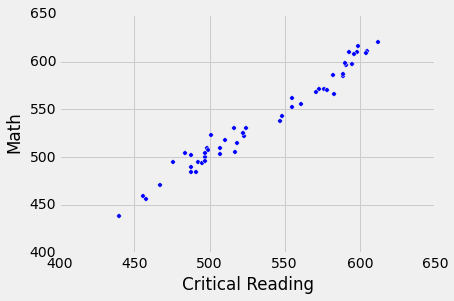

In [75]:
plots.scatter(sat2014['Critical Reading'], sat2014['Math'])
plots.xlabel('Critical Reading')
plots.ylabel('Math')
None

In [49]:
corr(sat2014, 'Critical Reading', 'Math')

0.98475584110674341

It is important to note that this does not reflect the strength of the relation between the Math and Critical Reading scores of students. States don't take tests – students do. The data in the table have been created by lumping all the students in each state into a single point at the average values of the two variables in that state. But not all students in the state will be at that point, as students vary in their performance. If you plot a point for each student instead of just one for each state, there will be a cloud of points around each point in the figure above. The overall picture will be more fuzzy. The correlation between the Math and Critical Reading scores of the students will be lower than the value calculated based on state averages.

Correlations based on aggregates and averages are called *ecological correlations* and are frequently reported. As we have just seen, they must be interpreted with care.

### Serious or tongue-in-cheek?

In 2012, a [paper](http://www.biostat.jhsph.edu/courses/bio621/misc/Chocolate%20consumption%20cognitive%20function%20and%20nobel%20laurates%20%28NEJM%29.pdf) in the respected New England Journal of Medicine examined the relation between chocolate consumption and Nobel Prizes in a group of countries. The [Scientific American](http://blogs.scientificamerican.com/the-curious-wavefunction/chocolate-consumption-and-nobel-prizes-a-bizarre-juxtaposition-if-there-ever-was-one/) responded seriously;
[others](http://www.reuters.com/article/2012/10/10/us-eat-chocolate-win-the-nobel-prize-idUSBRE8991MS20121010#vFdfFkbPVlilSjsB.97) were more relaxed. The paper included the following graph:

![choc_Nobel](assets/images/chocoNobel.png)

See what you think about the analysis and also about the Reuters report that said, "The p-value Messerli calculated was 0.0001. 'This means that the odds of this being due to chance are less than 1 in 10,000," he said."